<a href="https://colab.research.google.com/github/igorgad/covid-ts-it/blob/master/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CoVID19 Time Series Modeling - Transformers

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import cufflinks as cf
import plotly.offline as py
import plotly.graph_objs as go
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))


!wget https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
!wget https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv

--2020-05-28 01:40:03--  https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1275639 (1.2M) [text/plain]
Saving to: ‘dpc-covid19-ita-regioni.json’

dpc-covid19-ita-reg 100%[===================>]   1.22M  --.-KB/s    in 0.09s   

2020-05-28 01:40:03 (14.1 MB/s) - ‘dpc-covid19-ita-regioni.json’ saved [1275639/1275639]

--2020-05-28 01:40:06--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com

# Loading Data

## Loading WHO Data


In [ ]:
df = pd.read_csv('time_series_covid19_confirmed_global.csv')
# Replace unkown province/state with the country name
df['Province/State'] = df['Country/Region'] + ':' + df['Province/State']
df.fillna({'Province/State': df['Country/Region']}, inplace=True)
who_df = df.iloc[:, 4:].T.astype(np.float32)
who_df.columns = df['Province/State']
who_df.index = pd.to_datetime(who_df.index).date
who_df.head()

Province/State,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia:Australian Capital Territory,Australia:New South Wales,Australia:Northern Territory,Australia:Queensland,Australia:South Australia,Australia:Tasmania,Australia:Victoria,Australia:Western Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cabo Verde,Cambodia,Cameroon,Canada:Alberta,Canada:British Columbia,Canada:Grand Princess,Canada:Manitoba,Canada:New Brunswick,...,Uzbekistan,Venezuela,Vietnam,Zambia,Zimbabwe,Canada:Diamond Princess,Dominica,Grenada,Mozambique,Syria,Timor-Leste,Belize,Laos,Libya,West Bank and Gaza,Guinea-Bissau,Mali,Saint Kitts and Nevis,Canada:Northwest Territories,Canada:Yukon,Kosovo,Burma,United Kingdom:Anguilla,United Kingdom:British Virgin Islands,United Kingdom:Turks and Caicos Islands,MS Zaandam,Botswana,Burundi,Sierra Leone,"Netherlands:Bonaire, Sint Eustatius and Saba",Malawi,United Kingdom:Falkland Islands (Malvinas),France:Saint Pierre and Miquelon,South Sudan,Western Sahara,Sao Tome and Principe,Yemen,Comoros,Tajikistan,Lesotho
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


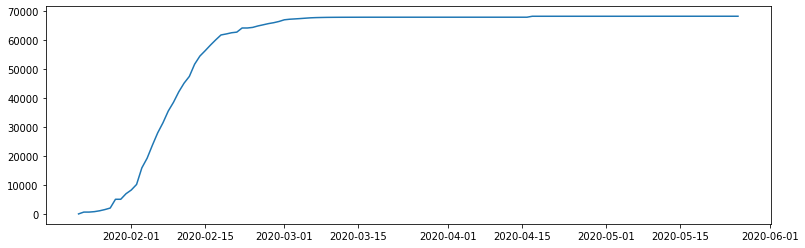

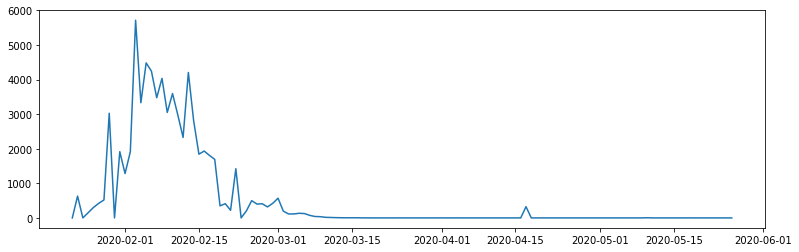

In [ ]:
def fix_hubei_data(sub_data):
    index = np.where(who_df['China:Hubei'].index == pd.to_datetime('2020-02-12'))[0][0] + 1
    # Shift data one day to the future
    sub_data.iloc[:index] = np.concatenate([np.zeros([1,]), sub_data.iloc[:index-1].values])

    # Apply parameter to normalize lab tested cases and clinical + lab tested cases
    sub_data.iloc[:index] = sub_data.iloc[:index] * (1 + 15384 / 36602)
    sub_data.iloc[index] = sub_data.iloc[index] * (0.65 + 15384 / 36602)

    return sub_data

# Fix Hubei data
if 'China:Hubei' in who_df.columns:
    who_df['China:Hubei'] = fix_hubei_data(who_df['China:Hubei'])

who_df['China:Hubei'].plot(figsize=(13, 4))
plt.figure()
who_df['China:Hubei'].diff().fillna(0).plot(figsize=(13, 4))

Total number of places (Province/State/Country/Region): 5


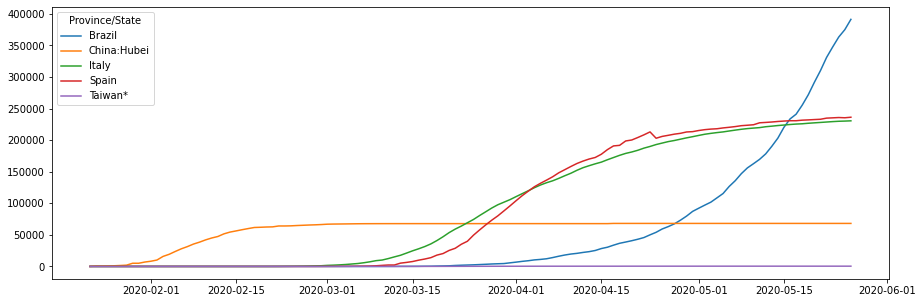

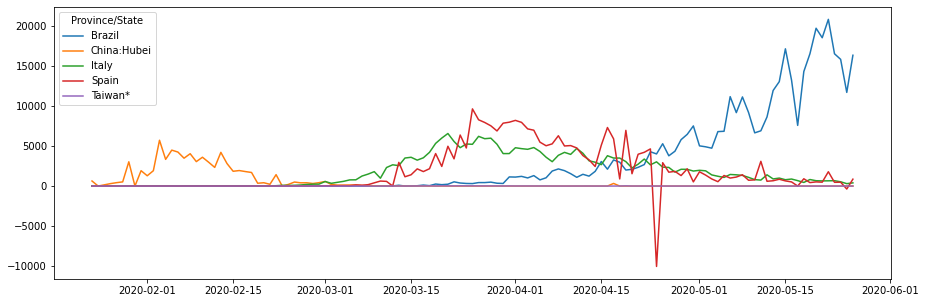

In [ ]:
# Select which countries/regions to use on the dataset
selected_regions = ['China:Hubei', 'Taiwan*', 'Italy', 'Brazil', 'Spain']
rdf = who_df.loc[:, who_df.columns.str.contains(r'|'.join(selected_regions))]

print('Total number of places (Province/State/Country/Region): ' + str(len(rdf.columns)))
rdf.plot(figsize=(15, 5))
rdf.diff().fillna(axis=1, method='ffill').plot(figsize=(15, 5))

## Loading JHU-US Data


In [ ]:
df = pd.read_csv('time_series_covid19_confirmed_US.csv')
# Replace unkown province/state with the country name
# df['Province_State'] = df.Combined_Key.apply(lambda key: ':'.join(key.split(',')[::-1]))
df['Province_State'] = df.Country_Region + ':' + df.Province_State
df.fillna({'Province_State': df['Country_Region']}, inplace=True)
us_df = df.groupby('Province_State').sum().iloc[:, 11:].T.astype(np.float32)
us_df.index = pd.to_datetime(us_df.index).date

beg_index = pd.date_range(who_df.index[0], us_df.first_valid_index() - pd.DateOffset(1)).date
beg_zero_df = pd.DataFrame(np.zeros([len(beg_index), len(us_df.columns)]),
                columns=us_df.columns,
                index=beg_index)

us_df = pd.concat([beg_zero_df, us_df], axis=0)
us_df

Province_State,US:Alabama,US:Alaska,US:American Samoa,US:Arizona,US:Arkansas,US:California,US:Colorado,US:Connecticut,US:Delaware,US:Diamond Princess,US:District of Columbia,US:Florida,US:Georgia,US:Grand Princess,US:Guam,US:Hawaii,US:Idaho,US:Illinois,US:Indiana,US:Iowa,US:Kansas,US:Kentucky,US:Louisiana,US:Maine,US:Maryland,US:Massachusetts,US:Michigan,US:Minnesota,US:Mississippi,US:Missouri,US:Montana,US:Nebraska,US:Nevada,US:New Hampshire,US:New Jersey,US:New Mexico,US:New York,US:North Carolina,US:North Dakota,US:Northern Mariana Islands,US:Ohio,US:Oklahoma,US:Oregon,US:Pennsylvania,US:Puerto Rico,US:Rhode Island,US:South Carolina,US:South Dakota,US:Tennessee,US:Texas,US:Utah,US:Vermont,US:Virgin Islands,US:Virginia,US:Washington,US:West Virginia,US:Wisconsin,US:Wyoming
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-22,13670.0,403.0,0.0,15624.0,5612.0,90252.0,23487.0,39640.0,8529.0,49.0,7893.0,49451.0,41482.0,103.0,165.0,642.0,2595.0,105444.0,30409.0,16492.0,8909.0,8426.0,36925.0,1948.0,44424.0,90889.0,53913.0,19005.0,12625.0,11836.0,479.0,11662.0,7525.0,4014.0,152579.0,6625.0,358154.0,22110.0,2317.0,22.0,30794.0,5849.0,3864.0,70211.0,3030.0,13736.0,9638.0,4356.0,19394.0,53539.0,8057.0,952.0,69.0,34950.0,19265.0,1705.0,14396.0,803.0
2020-05-23,14117.0,407.0,0.0,16053.0,5775.0,92539.0,23964.0,40022.0,8529.0,49.0,7966.0,50127.0,42242.0,103.0,165.0,643.0,2595.0,107796.0,30901.0,16898.0,8946.0,8571.0,36925.0,2013.0,45495.0,91662.0,54365.0,19845.0,13005.0,11966.0,479.0,11963.0,7526.0,4089.0,153140.0,6625.0,359926.0,22864.0,2365.0,22.0,31408.0,5960.0,3888.0,71009.0,3100.0,13952.0,9895.0,4464.0,19785.0,54776.0,8260.0,954.0,69.0,35749.0,19265.0,1705.0,14877.0,813.0
2020-05-24,14478.0,407.0,0.0,16377.0,5922.0,94020.0,24174.0,40468.0,8809.0,49.0,8110.0,50867.0,42902.0,103.0,166.0,643.0,2626.0,110304.0,31376.0,17251.0,9004.0,8571.0,37169.0,2055.0,46313.0,92675.0,54679.0,20573.0,13260.0,12149.0,479.0,12134.0,7881.0,4149.0,154154.0,6943.0,361515.0,23365.0,2418.0,22.0,31911.0,6037.0,3927.0,71563.0,3189.0,14065.0,10096.0,4563.0,20111.0,55861.0,8392.0,956.0,69.0,36244.0,19828.0,1759.0,15277.0,838.0
2020-05-25,14986.0,408.0,0.0,16575.0,6029.0,96400.0,24256.0,40873.0,8965.0,49.0,8225.0,51746.0,43400.0,103.0,166.0,643.0,2626.0,112017.0,31715.0,17557.0,9125.0,8571.0,37809.0,2074.0,47152.0,93271.0,54881.0,21315.0,13458.0,12476.0,479.0,12362.0,7956.0,4197.0,155092.0,7026.0,362764.0,24057.0,2457.0,22.0,32477.0,6090.0,3949.0,71925.0,3260.0,14065.0,10178.0,4586.0,20535.0,56409.0,8521.0,962.0,69.0,37727.0,20065.0,1774.0,15584.0,843.0


Total number of places (Province/State/Country/Region): 1


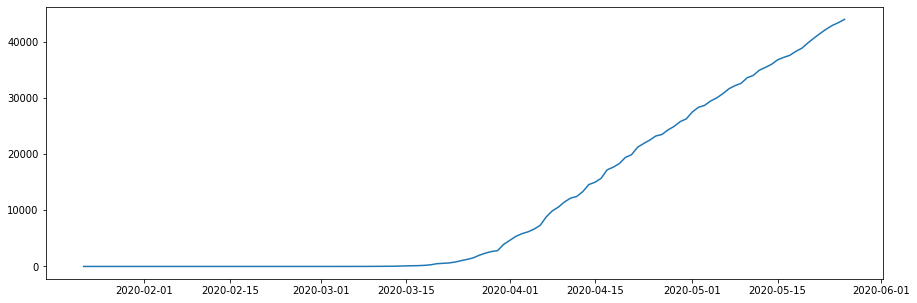

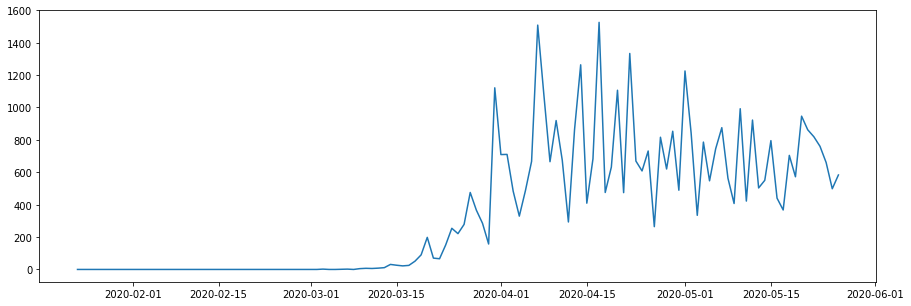

In [ ]:
# Select which countries/regions to use on the dataset
selected_regions = ['Georgia']
rdf = us_df.loc[:, us_df.columns.str.contains(r'|'.join(selected_regions))]

print('Total number of places (Province/State/Country/Region): ' + str(len(rdf.columns)))
rdf.plot(figsize=(15, 5), legend=False)
rdf.diff().fillna(axis=1, method='ffill').plot(figsize=(15, 5), legend=False)

## Load Brazil Data

In [ ]:
#Using MS data
# Run download_button.click() again if arquivo_geral.csv does not exist
bdf_ms = pd.read_csv('cases-brazil-states.csv')
bdf_ms.date = pd.to_datetime(bdf_ms.date, format="%Y/%m/%d").dt.date
bdf_ms.index = bdf_ms.date
states = bdf_ms['state'].unique()
dates = bdf_ms.date.drop_duplicates()
bdf_ms

,date,country,state,city,newDeaths,deaths,newCases,totalCases,deathsMS,totalCasesMS,deaths_per_100k_inhabitants,totalCases_per_100k_inhabitants,deaths_by_totalCases,recovered,suspects,tests,tests_per_100k_inhabitants
date,,,,,,,,,,,,,,,,,
2020-02-25,2020-02-25,Brazil,SP,TOTAL,0,0,1,1,0,0,0.00000,0.00218,0.00000,NaN,NaN,NaN,NaN
2020-02-25,2020-02-25,Brazil,TOTAL,TOTAL,0,0,1,1,0,0,0.00000,0.00048,0.00000,NaN,NaN,NaN,NaN
2020-02-26,2020-02-26,Brazil,SP,TOTAL,0,0,0,1,0,1,0.00000,0.00218,0.00000,NaN,NaN,NaN,NaN
2020-02-26,2020-02-26,Brazil,TOTAL,TOTAL,0,0,0,1,0,1,0.00000,0.00048,0.00000,NaN,NaN,NaN,NaN
2020-02-27,2020-02-27,Brazil,SP,TOTAL,0,0,0,1,0,1,0.00000,0.00218,0.00000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-27,2020-05-27,Brazil,SC,TOTAL,5,126,356,7372,126,7372,1.75860,102.89209,0.01709,4296.0,577.0,33062.0,461.45120
2020-05-27,2020-05-27,Brazil,SE,TOTAL,11,127,177,5912,127,5912,5.52487,257.18929,0.02148,2222.0,NaN,15438.0,671.59816
2020-05-27,2020-05-27,Brazil,SP,TOTAL,289,6712,3466,89483,6712,89483,14.61703,194.87120,0.07501,18245.0,180720.0,35600.0,77.52774


(127, 28)


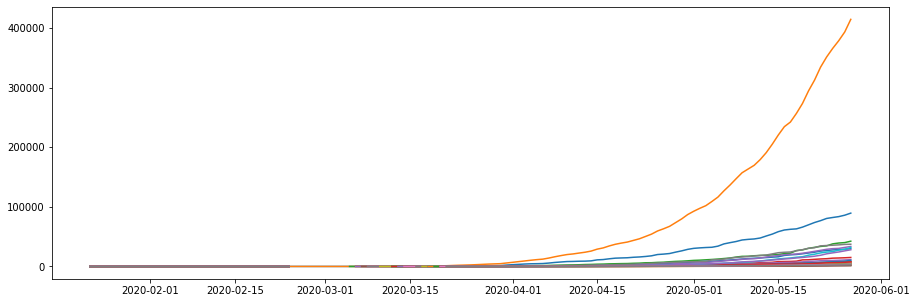

In [ ]:
br_df = pd.DataFrame(index=dates, columns=states)
for state in states:
    br_df[state] = bdf_ms[bdf_ms.state == state]['newCases'].cumsum()

br_df.columns = ['Brazil:' + s for s in br_df.columns]

beg_index = pd.date_range(who_df.index[0], br_df.first_valid_index() - pd.DateOffset(1)).date
beg_zero_df = pd.DataFrame(np.zeros([len(beg_index), len(br_df.columns)]),
                columns=br_df.columns,
                index=beg_index)
br_df = pd.concat([beg_zero_df, br_df], axis=0)

print(br_df.shape)
br_df.plot(figsize=(15, 5), legend=False)

## Load Italy Data

In [ ]:
ddf = pd.read_json('dpc-covid19-ita-regioni.json')
posdf = ddf[['denominazione_regione', 'lat', 'long']].drop_duplicates()
regions = ddf.denominazione_regione.unique()
ddf.data = pd.to_datetime(ddf.data).dt.date
ddf.set_index(ddf.data)
dates = ddf.data.unique()


it_df = pd.DataFrame(index=np.arange(len(dates)), columns=regions)
for region in regions:
    it_df[region] = ddf[ddf.denominazione_regione == region]['nuovi_positivi'].cumsum().values

it_df.index = dates
it_df.columns = ['Italy:' + s for s in it_df.columns]

beg_index = pd.date_range(who_df.index[0], it_df.first_valid_index() - pd.DateOffset(1)).date
beg_zero_df = pd.DataFrame(np.zeros([len(beg_index), len(it_df.columns)]),
                columns=it_df.columns,
                index=beg_index)
it_df = pd.concat([beg_zero_df, it_df], axis=0)

(127, 21)


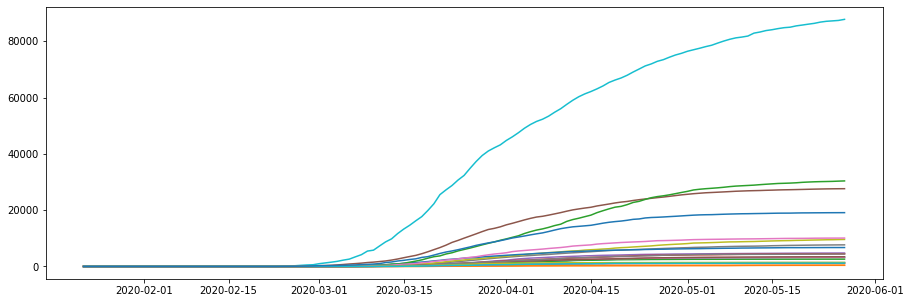

In [ ]:
it_df.plot(figsize=(15, 5), legend=False)
print(it_df.shape)

# Concatenate Data

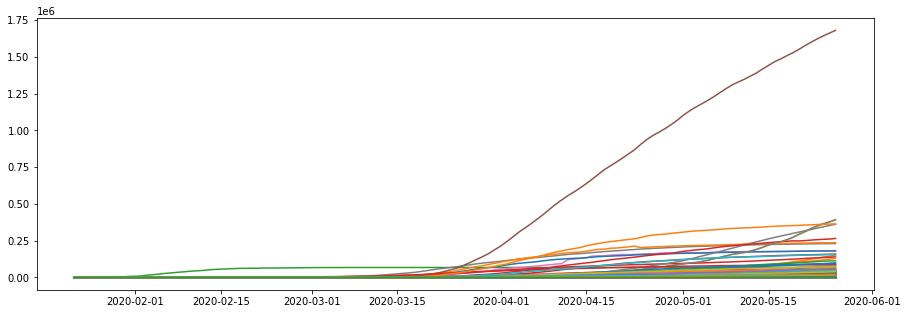

In [ ]:
last_valid_index = min([df.last_valid_index() for df in [who_df, br_df, it_df, us_df]])
sdf = pd.concat([who_df, br_df, it_df, us_df], axis=1).astype(np.float32)
sdf = sdf.loc[:last_valid_index, :]
# sdf = sdf.loc[:pd.to_datetime('2020-05-17'), :]

sdf.plot(figsize=(15,5), legend=False)

# Get Data Function

In [ ]:
# Normalize data by the day of the first case
def normalize_by_day_of_first_case(sdf):
    date_index = pd.DatetimeIndex(sdf.index)
    day_of_first_case = sdf.ne(0).idxmax()
    shifts = []
    for region in sdf.columns:
        shift_index = np.where(sdf.index == day_of_first_case[region])[0][0]
        sdf[region] = sdf[region].shift(-1 * shift_index, fill_value=np.nan) #sdf[region][-1])
        shifts.append(shift_index)

    sdf.index = np.arange(len(sdf.index))
    shifts_df = pd.DataFrame(np.expand_dims(np.array(shifts), 0), columns=sdf.columns)
    return sdf, day_of_first_case

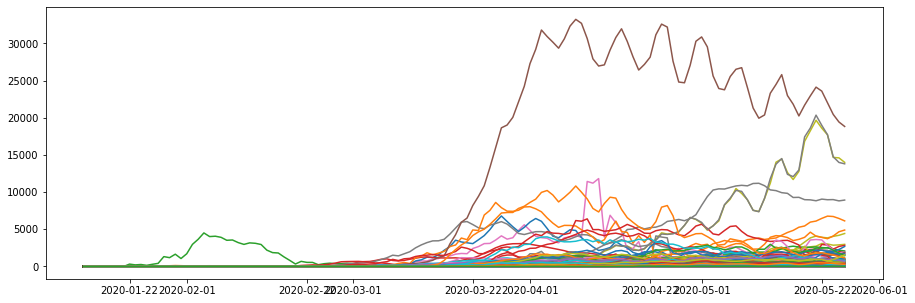

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def get_data(df, regions=['China'], partial_match=False, pad_start=None, pad_end=None, normalization=None, average_size=1, normalize_by_first_case=False, include_reverse=False):
    # Select which countries/regions to use on the dataset
    if regions:
        if partial_match:
            data = df.loc[:, df.columns.str.contains(r'|'.join(regions))]
        else:
            regions = [reg for reg in regions if reg in df]
            data = df.loc[:, regions]
    else:
        data = df
    

    # Differentiate to obtain daily cases
    # data = data.diff(axis=0).astype(np.float32)
    # data = data.diff(axis=0).fillna(0.0).astype(np.float32)
    data = data.diff(axis=0).fillna(data).astype(np.float32)

    # Moving Average
    # data = data.rolling(average_size, min_periods=1).mean() #.fillna(data)
    data = data.rolling(average_size, min_periods=1, win_type=None, center=True).mean() #.fillna(data)
    # data = data.ewm(span=average_size, ignore_na=True, min_periods=1).mean() #.fillna(data) 

    data = data.where(data > 0, 0.0)

    if pad_start:
        # Pad the Begging and End of data
        beg_index = pd.date_range(data.index[0] - pd.DateOffset(pad_start), data.index[0] - pd.DateOffset(1)).date
        beg_zero_df = pd.DataFrame(np.zeros([len(beg_index), len(data.columns)]),
                        columns=data.columns,
                        index=beg_index)
        data = pd.concat([beg_zero_df, data], axis=0)
        
    if pad_end:
        end_index = pd.date_range(data.index[-1] + pd.DateOffset(1), data.index[-1] + pd.DateOffset(pad_end)).date
        end_zero_df = pd.DataFrame(np.nan * np.ones([len(end_index), len(data.columns)]),
                        columns=data.columns,
                        index=end_index)
        
        data = pd.concat([data, end_zero_df], axis=0)
    
    # Normalizing
    scaler = None
    if normalization == 'MinMax':
        scaler = MinMaxScaler()
        data[data.columns] = scaler.fit_transform(data[data.columns])
    if normalization == 'Standard':
        scaler = StandardScaler()
        data[data.columns] = scaler.fit_transform(data[data.columns])

    if normalize_by_first_case:
        data = normalize_by_day_of_first_case(data)[0]
    
    if include_reverse:
        rev = data[::-1]
        rev.columns = [c + ':REV' for c in rev.columns]
        rev.index = rev.index[::-1]
        data = pd.concat([data, rev], axis=1)

    return data, scaler

data, _ = get_data(sdf, regions=None, pad_start=8, pad_end=None, normalization=None, average_size=3, normalize_by_first_case=False, include_reverse=False)
data.plot(figsize=(15, 5), legend=False)

# Transformers

## Sequences Generation

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

class tsGenerator(TimeseriesGenerator):
    def __init__(self, *args, **kwargs):
        self.norm = kwargs.pop('normalization')
        super(tsGenerator, self).__init__(*args, **kwargs)

    def __getitem__(self, index):
        samples, targets = super().__getitem__(index)
        samples = np.reshape(np.transpose(samples, [0, 2, 1]), [-1, self.length])
        targets = np.reshape(np.expand_dims(targets, -1), [-1, 1])

        # Normalizing
        if self.norm == 'Standard':
            S = samples.std(axis=1, keepdims=True)
            M = samples.mean(axis=1, keepdims=True)
            samples = np.divide(samples - M, S, out=np.zeros_like(samples), where=S!=0)
            targets = np.divide(targets - M, S, out=np.zeros_like(targets), where=S!=0)

        if self.norm == 'DivMean':
            M = samples.mean(axis=1, keepdims=True)
            samples = np.divide(samples, M, out=np.zeros_like(samples), where=M!=0)
            targets = np.divide(targets, M, out=np.zeros_like(targets), where=M!=0)
        
        if self.norm == 'MinMax':
            max = samples.max(axis=1, keepdims=True)
            min = samples.min(axis=1, keepdims=True)
            minmaxdiff = max - min
            samples = np.divide(samples - min, minmaxdiff, out=np.zeros_like(samples), where=minmaxdiff!=0)
            targets = np.divide(targets - min, minmaxdiff, out=np.zeros_like(targets), where=minmaxdiff!=0)
        return samples, np.concatenate([samples[:, [-1]], targets[:, [0]]], axis=1)

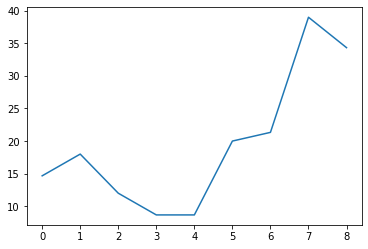

In [ ]:
def get_sequence_generator(data, normalization='divmean', length=8, shuffle=True, batch_size=1):
    generator = tsGenerator(data.values, data.values, length=length, batch_size=batch_size, normalization=normalization, shuffle=shuffle)
    return generator

generator = get_sequence_generator(data, normalization='divmean', shuffle=False)
train_exs = 0
for i, (x, y) in enumerate(generator):
    train_exs += 1

x, y = generator[70]
plt.plot(np.concatenate([x[0,:], y[0, [-1]]]))

## Training Loop

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=500):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
def train(models, train_generator, eval_generator, lr=1e-3, epochs=100, d_model=None, warmup_steps=1000):
    if d_model:
        lr = CustomSchedule(d_model, warmup_steps=warmup_steps)

    def train_model(model):
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=0),
            # tf.keras.callbacks.ModelCheckpoint(workspace + '/Checkpoints/MAE', monitor='val_loss', save_best_only=True, verbose=0)
        ]

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9), 
                      loss='mse')


        trace = model.fit(train_generator, epochs=epochs, validation_data=eval_generator, callbacks=callbacks, verbose=1)
        # tf.keras.backend.clear_session()
        return trace
    return [train_model(model) for model in models]

## Evaluation Loop

In [ ]:
def forecast(model, generator, forecast_start_day=None, normalization='DivMean'):
    xi, yi = generator[0]

    predicted_values = np.zeros([xi.shape[0], 0])
    true_values = np.zeros([xi.shape[0], 0])

    # Iterate over a set with support data
    for i, (ex, y) in enumerate(generator):
        if forecast_start_day:
            x = ex if i < forecast_start_day else x
        else:
            x = ex if ~np.isnan(ex).any() else x
                
        # Normalize
        xi = x
        if normalization == 'Standard':
            S = x.std(axis=1, keepdims=True)
            M = x.mean(axis=1, keepdims=True)
            xi = np.divide(x - M, S, out=np.zeros_like(x), where=S!=0)
        if normalization == 'DivMean':
            M = x.mean(axis=1, keepdims=True)
            xi = np.divide(x, M, out=np.zeros_like(x), where=M!=0)
        if normalization == 'DivMax':
            M = x.max(axis=1, keepdims=True)
            xi = np.divide(x, M, out=np.zeros_like(x), where=M!=0)
        if normalization == 'MinMax':
            max = x.max(axis=1, keepdims=True)
            min = x.min(axis=1, keepdims=True)
            minmaxdiff = max - min
            xi = np.divide(x - min, minmaxdiff, out=np.zeros_like(x), where=minmaxdiff!=0)
        # Predict
        outs = [model.predict(xi) for model in models]
        # Average models predictions
        pred = np.stack([out[:, [-1]] for out in outs]).mean(0)
        # Restore
        if normalization == 'Standard':
            pred = pred * S + M
        if normalization == 'DivMean':
            pred = pred * M
        if normalization == 'DivMax':
            pred = pred * M
        if normalization == 'MinMax':
            pred = pred * minmaxdiff + min
        # Append
        predicted_values = np.concatenate([predicted_values, pred], axis=1)
        true_values = np.concatenate([true_values, y[:, [-1]]], axis=1)
        # Shift
        x = np.concatenate([x, pred], axis=1)[:, 1:]        

    return predicted_values.T, true_values.T


## Transformers Layers

### Positional Encoding Layer

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], 
            d_model=d_model)
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

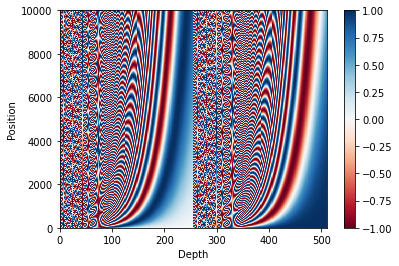

In [ ]:
sample_pos_encoding = PositionalEncoding(10000, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Attention Layer

In [ ]:
a = tf.ones((1, 16, 8))
a = tf.reshape(a, (1, -1, 4, 2))
a = tf.transpose(a, [0, 2, 1, 3])
b = tf.shape(a)
b.numpy()

array([ 1,  4, 16,  2], dtype=int32)

In [ ]:
def scaled_dot_product_attention(query, key, value):
    matmul_qk = tf.matmul(query, key, transpose_b=True) #(bs, 4, 16, 16)

    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth) #(bs, 4, 16, 16) - Normalize by squared mean of head depth

    # add the mask zero out padding tokens.
    # if mask is not None:
    #     logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1) # (bs, 4, 16, 16)
    attentioned = tf.matmul(attention_weights, value) # (bs, 4, 16, 16) * (bs, 4, 16, 2) = (bs, 4, 16, 2)
    # attentioned = tf.ensure_shape(attentioned, tf.shape(value))
    return attentioned


class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads # 2 = 8 // 4
        self.query_dense = tf.keras.layers.Dense(units=d_model) # 8
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth)) # (bs, 16, 8) -> (bs,  16, 4, 2)
        return tf.transpose(inputs, perm=[0, 2, 1, 3]) # (bs,  16, 4, 2) -> (bs, 4, 16, 2)

    def call(self, inputs):
        query, key, value = inputs['query'], inputs['key'], inputs['value']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query) # (bs, 16, 8)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size) # (bs, 4, 16, 2)
        key = self.split_heads(key, batch_size) # (bs, 4, 16, 2)
        value = self.split_heads(value, batch_size) # (bs, 4, 16, 2)

        scaled_attention = scaled_dot_product_attention(query, key, value) # (bs, 4, 16, 2)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # (bs, 4, 16, 2) -> (bs, 16, 4, 2)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) # (bs, 16, 8)
        outputs = self.dense(concat_attention) # (bs, 16, 8)
        return outputs

### Encoder Layer

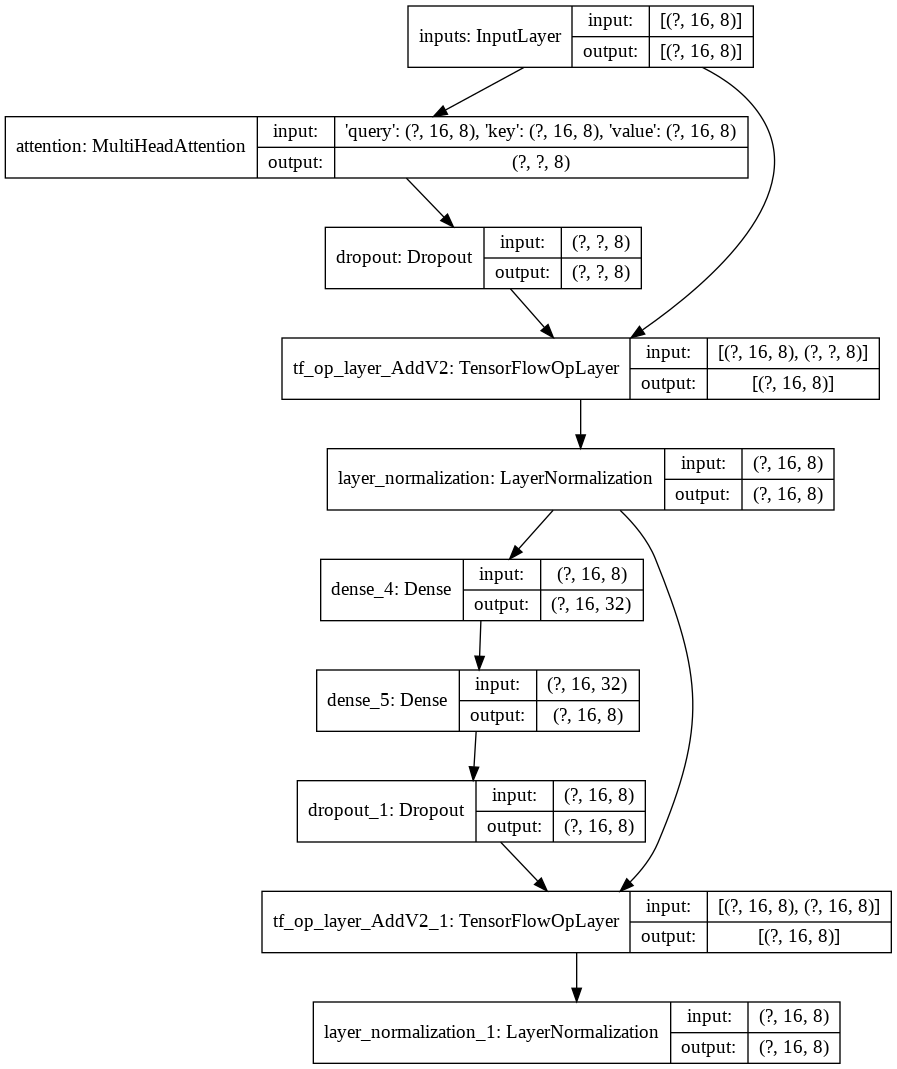

In [ ]:
def encoder_layer(sequence_length, units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(sequence_length, d_model), name="inputs")

    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs
        })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

sample_encoder_layer = encoder_layer(16, 32, 8, 4, 0.5)
tf.keras.utils.plot_model(sample_encoder_layer, show_shapes=True, show_layer_names=True, to_file='model.png')

### Decoder Layer

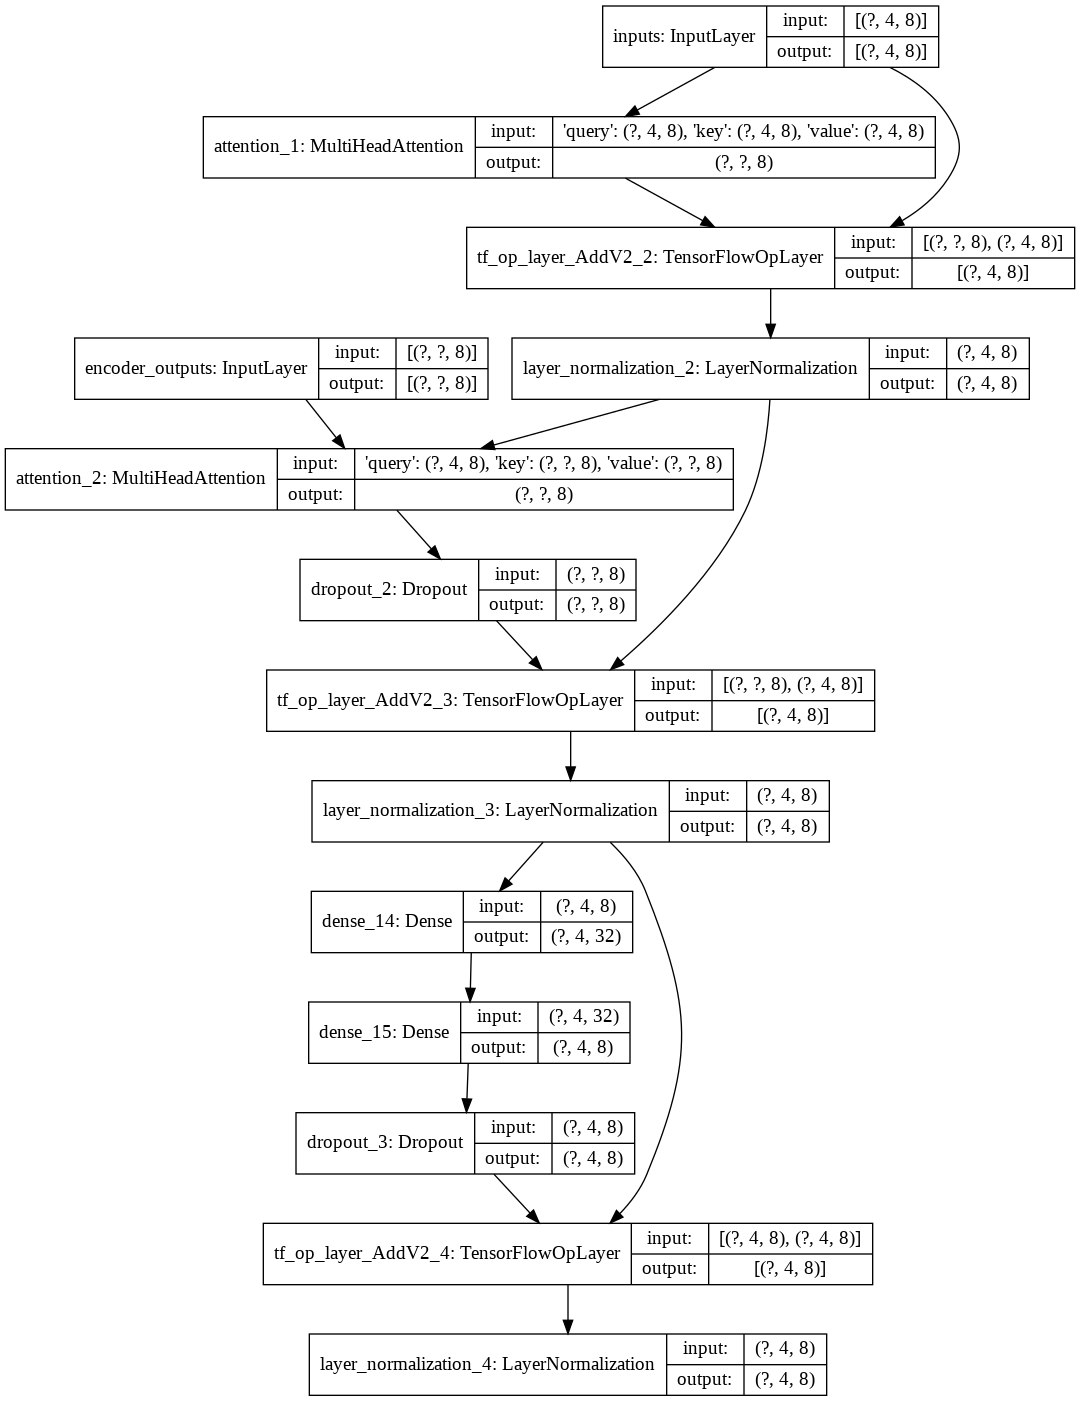

In [ ]:
def decoder_layer(sequence_length, units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(sequence_length, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs
        })
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs
        })
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs],
        outputs=outputs,
        name=name)

sample_decoder_layer = decoder_layer(4, 32, 8, 4, 0.5)
tf.keras.utils.plot_model(sample_decoder_layer, show_shapes=True, show_layer_names=True, to_file='model.png')

## Transformers Model

### Encoder

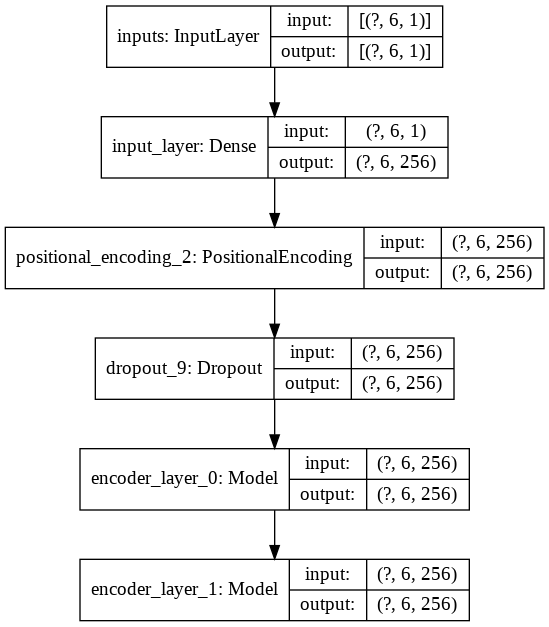

In [ ]:
def encoder(sequence_length,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(sequence_length, 1), name="inputs")

    encoded_inputs = tf.keras.layers.Dense(d_model, name='input_layer')(inputs)
    encoded_position = PositionalEncoding(10000, d_model)(encoded_inputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(encoded_position)

    layer_outputs = []
    for i in range(num_layers):
        outputs = encoder_layer(sequence_length=sequence_length,
                                units=units,
                                d_model=d_model,
                                num_heads=num_heads,
                                dropout=dropout,
                                name="encoder_layer_{}".format(i))(outputs)
        layer_outputs.append(outputs)

    return tf.keras.Model(inputs=inputs, outputs=layer_outputs, name=name)


sample_encoder = encoder(6, 2, 512, 256, 4, 0.5)
tf.keras.utils.plot_model(sample_encoder, show_shapes=True, show_layer_names=True, to_file='model.png')

### Decoder

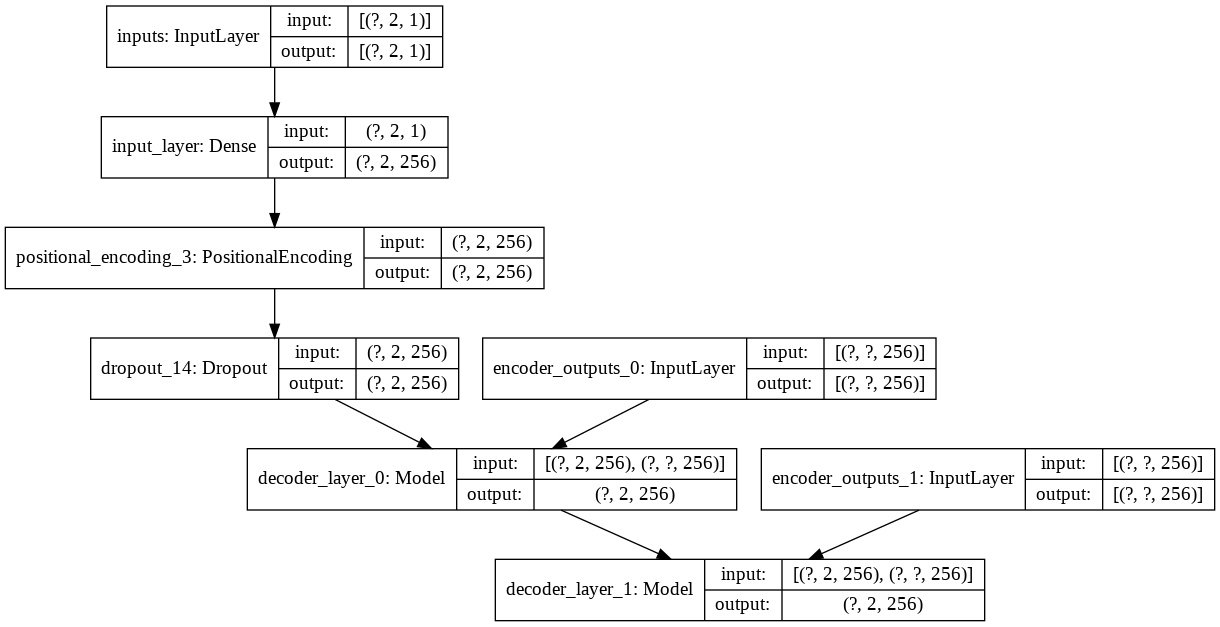

In [ ]:
def decoder(sequence_length,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(sequence_length, 1), name='inputs')
    enc_outputs = [tf.keras.Input(shape=(None, d_model), name='encoder_outputs_%d' % i) for i in range(num_layers)]

    encoded_inputs = tf.keras.layers.Dense(d_model, name='input_layer')(inputs)
    embeddings = PositionalEncoding(10000, d_model)(encoded_inputs)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            sequence_length=sequence_length,
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs[i]])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs],
        outputs=outputs,
        name=name)
    
sample_decoder = decoder(2, 2, 512, 256, 8, 0.5)
tf.keras.utils.plot_model(sample_decoder, show_shapes=True, show_layer_names=True, to_file='model.png')

### Encoder - Decoder

In [ ]:
# Parameters
train_regions = ['China', 'Taiwan*']
eval_regions = ['Italy']
num_models = 1
data_normalization = 'MinMax'  #None
block_normalization = None #'DivMean'
sequence_length = 8
d_model = 256
num_heads = 8
num_layers = 2
units = 512
lr = 1e-4
dropout = 0.1
pad_start = sequence_length
average_size = 5
seed = 0

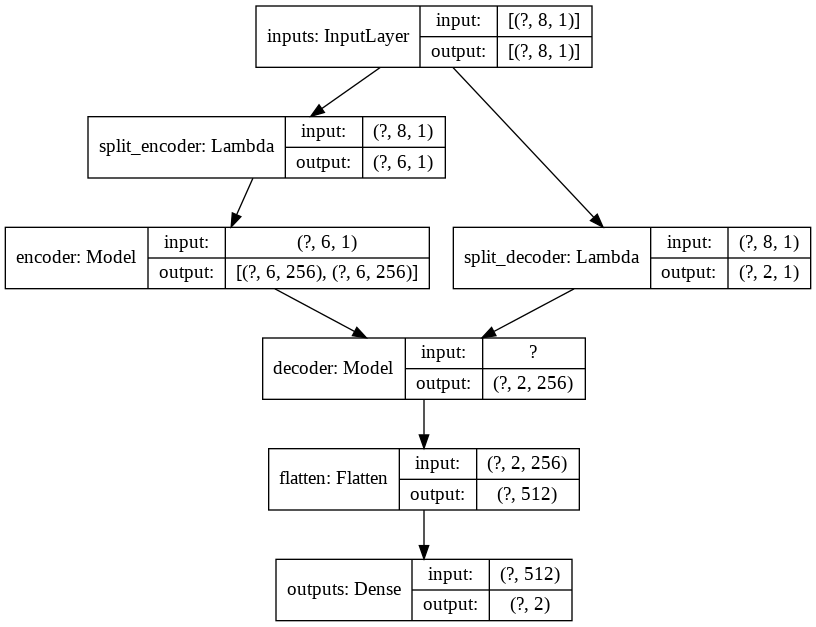

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed)
np.random.seed(seed)


def transformers(sequence_length,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer",
                split_index=2):
    inputs = tf.keras.Input(shape=(sequence_length, 1), name="inputs")

    enc_inputs = tf.keras.layers.Lambda(lambda x: x[:, :-split_index, :], name='split_encoder')(inputs)
    dec_inputs = tf.keras.layers.Lambda(lambda x: x[:, -split_index:, :], name='split_decoder')(inputs)

    enc_outputs = encoder(
        sequence_length=sequence_length - split_index,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=enc_inputs)

    dec_outputs = decoder(
        sequence_length=split_index,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs] + enc_outputs)

    outputs = tf.keras.layers.Flatten()(dec_outputs)
    outputs = tf.keras.layers.Dense(units=split_index, name="outputs")(outputs)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

models = [transformers(sequence_length, num_layers, units, d_model, num_heads, dropout) for _ in range(num_models)]
tf.keras.utils.plot_model(models[0], show_shapes=True, show_layer_names=True, to_file='model.png')

## Training

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.6176 - val_loss: 4.3081 - lr: 1.0000e-04
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 4.0407 - val_loss: 1.2735 - lr: 1.0000e-04
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 1.4923 - val_loss: 0.2205 - lr: 1.0000e-04
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.4643 - val_loss: 1.4235 - lr: 1.0000e-04
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 1.3668 - val_loss: 1.7032 - lr: 1.0000e-04
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 1.6032 - val_loss: 0.9592 - lr: 1.0000e-04
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 1.0029 - val_loss: 0.2675 - lr: 1.0000e-04
Epoch 8/100
1/1 [==============================] - 2s 2s/step - loss: 0.4508 - val_loss: 0.1301 - lr: 5.0000e-05
Epoch 9/100
1/1 [==============================] - 2s 2s/step - loss: 0.3397 - val_loss: 0.1277 

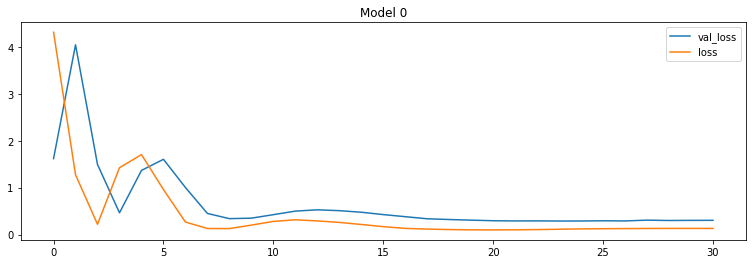

In [ ]:
train_data, _ = get_data(sdf, regions=train_regions, partial_match=True,
                         pad_start=pad_start, average_size=average_size, normalization=data_normalization, normalize_by_first_case=True, 
                         include_reverse=True)
eval_data, _ = get_data(sdf, regions=eval_regions, partial_match=True,
                         pad_start=pad_start, average_size=average_size, normalization=data_normalization, normalize_by_first_case=True, 
                         include_reverse=False)

train_generator = get_sequence_generator(train_data.fillna(0.0), length=sequence_length, normalization=block_normalization, shuffle=True, batch_size=512)
eval_generator = get_sequence_generator(eval_data.fillna(0.0), length=sequence_length, normalization=block_normalization, shuffle=False, batch_size=1)

traces = train(models, train_generator, eval_generator, lr=lr, epochs=100)

for i,trace in enumerate(traces):
    pd.DataFrame(np.stack([trace.history['loss'], 
                           trace.history['val_loss']], axis=1), 
                 columns={'loss', 'val_loss'}).plot(figsize=(13, 4), title='Model %d' % i)

## Forecasting

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.nanmean(np.divide(np.abs(y_true - y_pred), y_true, out=np.ones_like(y_true) * np.nan, where=y_true!=0), axis=0) * 100

#### China

                               MAPE      XCOR
China:Anhui             2892.060494 -0.907554
China:Beijing            237.500369 -0.807614
China:Chongqing         1268.995863 -0.910265
China:Fujian             744.691119 -0.894427
China:Gansu              242.892514 -0.735987
China:Guangdong         2869.374971 -0.897527
China:Guangxi            430.645565 -0.918644
China:Guizhou            378.131805 -0.895650
China:Hainan             308.370663 -0.913200
China:Hebei              763.105349 -0.925499
China:Heilongjiang      1714.726654 -0.533555
China:Henan             4583.608230 -0.902587
China:Hong Kong          580.378250 -0.241114
China:Hubei           155160.491009 -0.881501
China:Hunan             2393.394038 -0.911043
China:Inner Mongolia     143.330415 -0.152581
China:Jiangsu            801.337562 -0.924543
China:Jiangxi           4019.949036 -0.897873
China:Jilin              217.767943 -0.760298
China:Liaoning           348.443948 -0.892709
China:Macau               76.07000

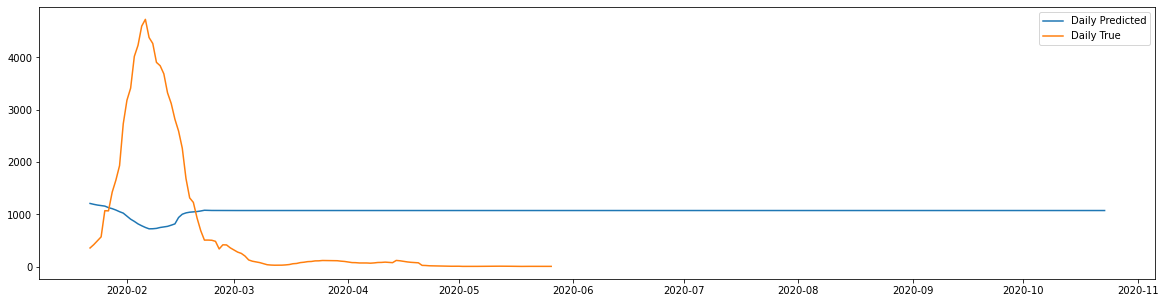

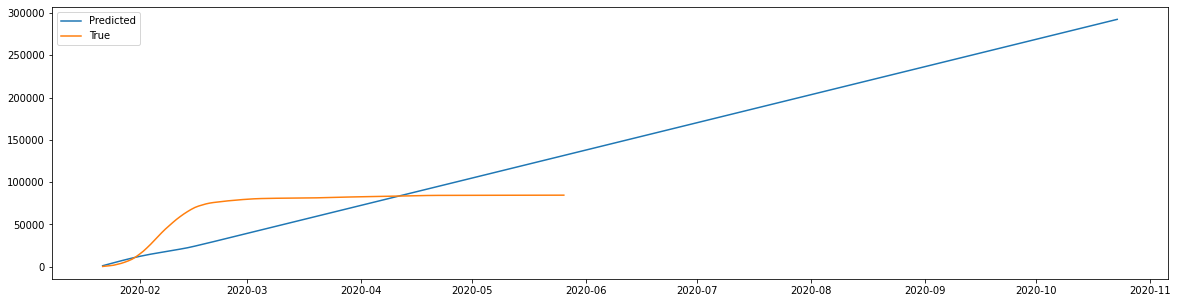

In [ ]:
forecast_regions = ['China', 'Taiwan*']
forecast_start_date = '2020-02-15'
forecast_average_size = 7
pad_start = sequence_length
days_ahead = 150

forecast_data, scaler = get_data(sdf, regions=forecast_regions, partial_match=True,
                                 normalization=data_normalization, pad_start=pad_start, pad_end=days_ahead, 
                                 average_size=forecast_average_size, normalize_by_first_case=False)

forecast_start_day = np.where(forecast_data.index == pd.to_datetime(forecast_start_date))[0][0] - pad_start if forecast_start_date else None
forecast_generator = get_sequence_generator(forecast_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = forecast(models, forecast_generator, forecast_start_day=forecast_start_day, normalization=block_normalization)

predicted_df = pd.DataFrame(preds, columns=forecast_data.columns, index=forecast_data.index[sequence_length:])
trues_df = pd.DataFrame(trues, columns=forecast_data.columns, index=forecast_data.index[sequence_length:])

if scaler:
    predicted_df.iloc[:, :] = scaler.inverse_transform(predicted_df.values)
    trues_df.iloc[:, :] = scaler.inverse_transform(trues_df.values)

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)
corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### Italy

                                   MAPE      XCOR
Italy                         46.661017  0.968469
Italy:Abruzzo                 39.398731  0.938777
Italy:Basilicata              61.796618  0.851329
Italy:P.A. Bolzano            88.983175  0.953389
Italy:Calabria                92.715045  0.888419
Italy:Campania                32.496761  0.977762
Italy:Emilia-Romagna          32.677647  0.960117
Italy:Friuli Venezia Giulia   32.763931  0.972731
Italy:Lazio                   49.128644  0.969110
Italy:Liguria                 56.948691  0.925731
Italy:Lombardia               46.924645  0.951841
Italy:Marche                  33.945859  0.964004
Italy:Molise                  53.254312  0.722341
Italy:Piemonte                59.965646  0.881317
Italy:Puglia                  42.253925  0.971417
Italy:Sardegna                75.483279  0.942625
Italy:Sicilia                 34.418305  0.919793
Italy:Toscana                 35.691414  0.973855
Italy:P.A. Trento             51.430266  0.947691


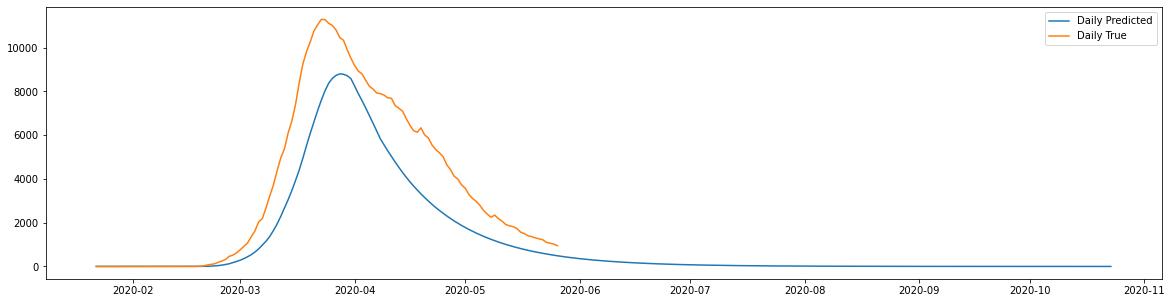

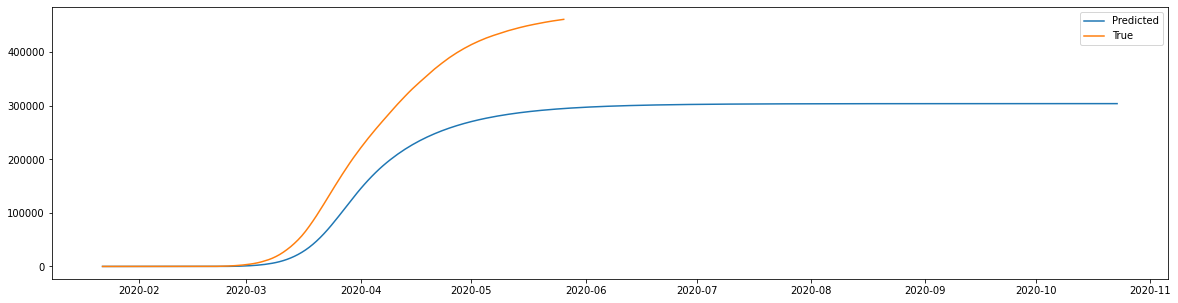

In [ ]:
forecast_regions = ['Italy']
forecast_start_date = '2020-04-01'
forecast_average_size = 7
pad_start = sequence_length
days_ahead = 150

forecast_data, scaler = get_data(sdf, regions=forecast_regions, partial_match=True,
                                 normalization=data_normalization, pad_start=pad_start, pad_end=days_ahead, 
                                 average_size=forecast_average_size, normalize_by_first_case=False)

forecast_start_day = np.where(forecast_data.index == pd.to_datetime(forecast_start_date))[0][0] - pad_start if forecast_start_date else None
forecast_generator = get_sequence_generator(forecast_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = forecast(models, forecast_generator, forecast_start_day=forecast_start_day, normalization=block_normalization)

predicted_df = pd.DataFrame(preds, columns=forecast_data.columns, index=forecast_data.index[sequence_length:])
trues_df = pd.DataFrame(trues, columns=forecast_data.columns, index=forecast_data.index[sequence_length:])

if scaler:
    predicted_df.iloc[:, :] = scaler.inverse_transform(predicted_df.values)
    trues_df.iloc[:, :] = scaler.inverse_transform(trues_df.values)

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)
corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### Brazil

                   MAPE      XCOR
Brazil        59.433826  0.624479
Brazil:SP     54.431176  0.760248
Brazil:TOTAL  59.141846  0.623068
Brazil:RJ     55.544228  0.553300
Brazil:BA     54.973869  0.546537
Brazil:ES     55.006936  0.661973
Brazil:DF     52.214679  0.497495
Brazil:AL     56.292073  0.610313
Brazil:MG     53.118854  0.461071
Brazil:RS     52.905235  0.444828
Brazil:GO     47.059421  0.581081
Brazil:PE     55.999022  0.707356
Brazil:PR     45.491096  0.487609
Brazil:RN     55.077908  0.568591
Brazil:SC     49.372322  0.733524
Brazil:AM     58.630174  0.642175
Brazil:MS     48.177505  0.243359
Brazil:SE     58.494717  0.692413
Brazil:CE     56.896649  0.640875
Brazil:AC     59.874846  0.468775
Brazil:PA     63.770165  0.523536
Brazil:PB     60.261662  0.537709
Brazil:TO     57.804624  0.642421
Brazil:PI     56.640986  0.658839
Brazil:AP     58.896296  0.580023
Brazil:MA     62.914775  0.468425
Brazil:MT     54.170485  0.308374
Brazil:RO     59.521966  0.624039
Brazil:RR     

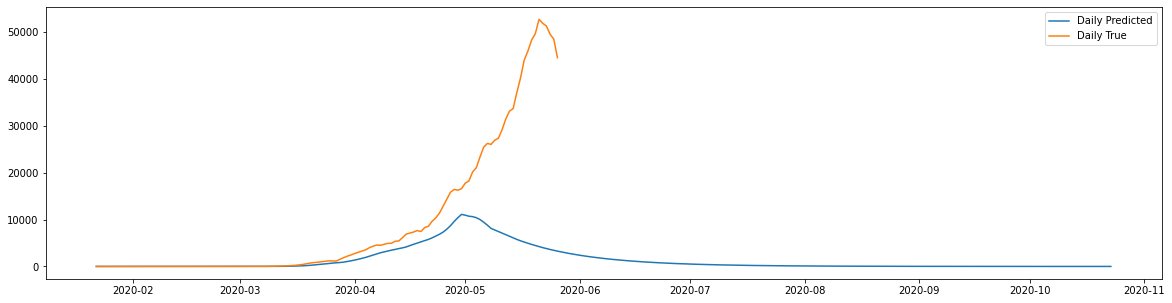

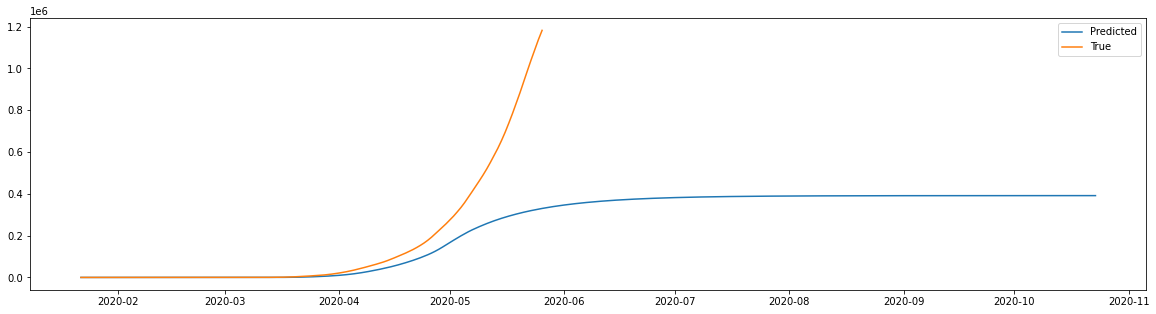

In [ ]:
forecast_regions = ['Brazil']
forecast_start_date = '2020-05-01'
forecast_average_size = 7
pad_start = sequence_length
days_ahead = 150

forecast_data, scaler = get_data(sdf, regions=forecast_regions, partial_match=True,
                                 normalization=data_normalization, pad_start=pad_start, pad_end=days_ahead, 
                                 average_size=forecast_average_size, normalize_by_first_case=False)

forecast_start_day = np.where(forecast_data.index == pd.to_datetime(forecast_start_date))[0][0] - pad_start if forecast_start_date else None
forecast_generator = get_sequence_generator(forecast_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = forecast(models, forecast_generator, forecast_start_day=forecast_start_day, normalization=block_normalization)

predicted_df = pd.DataFrame(preds, columns=forecast_data.columns, index=forecast_data.index[sequence_length:])
trues_df = pd.DataFrame(trues, columns=forecast_data.columns, index=forecast_data.index[sequence_length:])

if scaler:
    predicted_df.iloc[:, :] = scaler.inverse_transform(predicted_df.values)
    trues_df.iloc[:, :] = scaler.inverse_transform(trues_df.values)

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)
corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### Spain

             MAPE      XCOR
Spain  462.701298  0.508946
MAPE    462.701298
XCOR      0.508946
dtype: float64


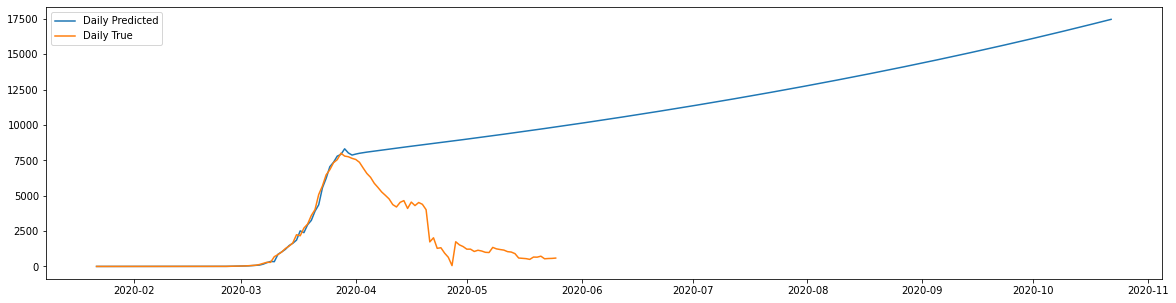

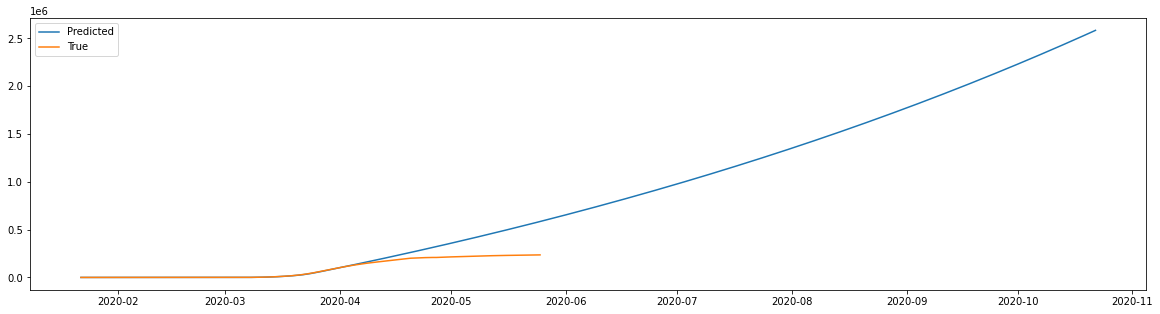

In [ ]:
forecast_regions = ['Spain']
forecast_start_date = '2020-04-01'
forecast_average_size = 7
pad_start = sequence_length
days_ahead = 150

forecast_data, scaler = get_data(sdf, regions=forecast_regions, partial_match=True,
                                 normalization=data_normalization, pad_start=pad_start, pad_end=days_ahead, 
                                 average_size=forecast_average_size, normalize_by_first_case=False)

forecast_start_day = np.where(forecast_data.index == pd.to_datetime(forecast_start_date))[0][0] - pad_start if forecast_start_date else None
forecast_generator = get_sequence_generator(forecast_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = forecast(models, forecast_generator, forecast_start_day=forecast_start_day, normalization=block_normalization)

predicted_df = pd.DataFrame(preds, columns=forecast_data.columns, index=forecast_data.index[sequence_length:])
trues_df = pd.DataFrame(trues, columns=forecast_data.columns, index=forecast_data.index[sequence_length:])

if scaler:
    predicted_df.iloc[:, :] = scaler.inverse_transform(predicted_df.values)
    trues_df.iloc[:, :] = scaler.inverse_transform(trues_df.values)

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)
corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### UK

                                                   MAPE      XCOR
United Kingdom:Bermuda                       172.140386  0.669625
United Kingdom:Cayman Islands                422.376014  0.656761
United Kingdom:Channel Islands              1842.158995  0.384384
United Kingdom:Gibraltar                    1127.988212  0.394731
United Kingdom:Isle of Man                  2271.568355  0.350167
United Kingdom:Montserrat                     37.573111  0.567616
United Kingdom                                33.208537  0.921181
United Kingdom:Anguilla                      156.374502  0.006256
United Kingdom:British Virgin Islands        285.575840  0.469843
United Kingdom:Turks and Caicos Islands      270.165132  0.392020
United Kingdom:Falkland Islands (Malvinas)   100.000000       NaN
MAPE    610.829917
XCOR      0.481258
dtype: float64


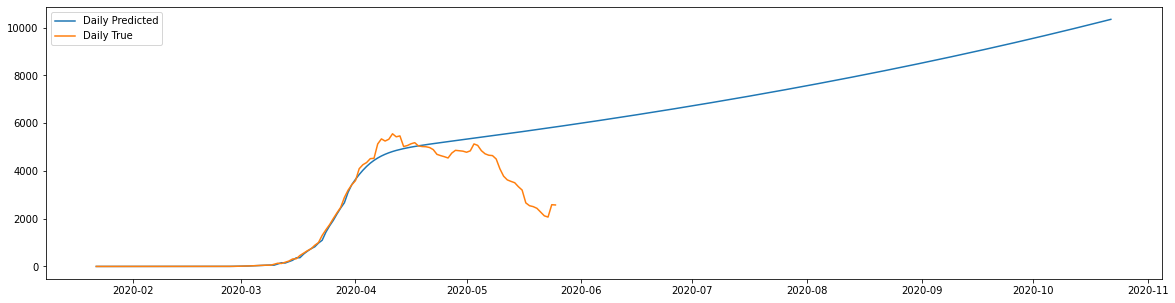

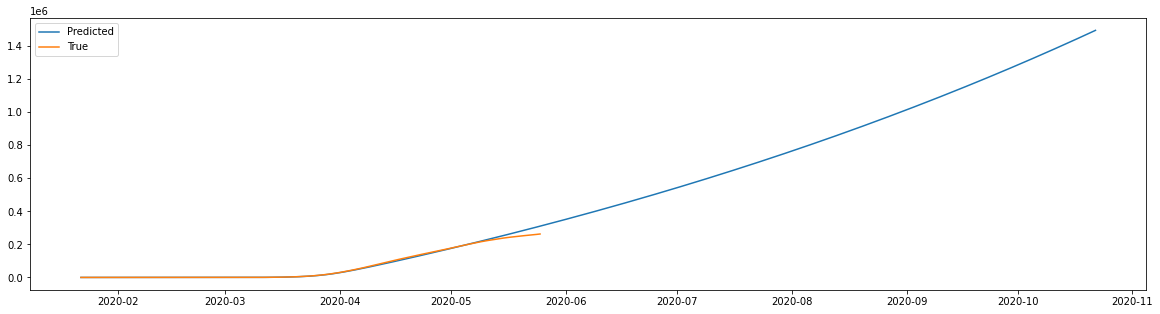

In [ ]:
forecast_regions = ['United Kingdom']
forecast_start_date = '2020-04-01'
forecast_average_size = 7
pad_start = sequence_length
days_ahead = 150

forecast_data, scaler = get_data(sdf, regions=forecast_regions, partial_match=True,
                                 normalization=data_normalization, pad_start=pad_start, pad_end=days_ahead, 
                                 average_size=forecast_average_size, normalize_by_first_case=False)

forecast_start_day = np.where(forecast_data.index == pd.to_datetime(forecast_start_date))[0][0] - pad_start if forecast_start_date else None
forecast_generator = get_sequence_generator(forecast_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = forecast(models, forecast_generator, forecast_start_day=forecast_start_day, normalization=block_normalization)

predicted_df = pd.DataFrame(preds, columns=forecast_data.columns, index=forecast_data.index[sequence_length:])
trues_df = pd.DataFrame(trues, columns=forecast_data.columns, index=forecast_data.index[sequence_length:])

if scaler:
    predicted_df.iloc[:, :] = scaler.inverse_transform(predicted_df.values)
    trues_df.iloc[:, :] = scaler.inverse_transform(trues_df.values)

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)
corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### US

                      MAPE      XCOR
Province/State                      
US              497.306034  0.930275
MAPE    497.306034
XCOR      0.930275
dtype: float64


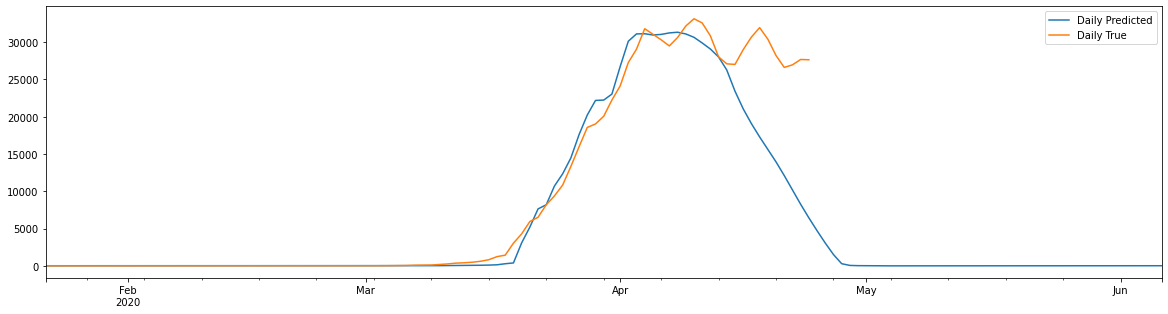

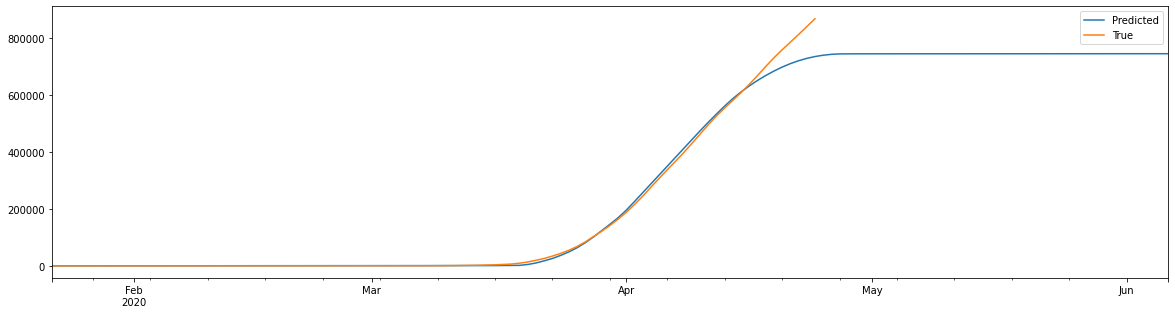

In [ ]:
forecast_regions = ['US']
forecast_start_date = '2020-04-01'
forecast_average_size = 7
pad_start = sequence_length
days_ahead = 150

forecast_data, scaler = get_data(sdf, regions=forecast_regions, partial_match=True,
                                 normalization=data_normalization, pad_start=pad_start, pad_end=days_ahead, 
                                 average_size=forecast_average_size, normalize_by_first_case=False)

forecast_start_day = np.where(forecast_data.index == pd.to_datetime(forecast_start_date))[0][0] - pad_start if forecast_start_date else None
forecast_generator = get_sequence_generator(forecast_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = forecast(models, forecast_generator, forecast_start_day=forecast_start_day, normalization=block_normalization)

predicted_df = pd.DataFrame(preds, columns=forecast_data.columns, index=forecast_data.index[sequence_length:])
trues_df = pd.DataFrame(trues, columns=forecast_data.columns, index=forecast_data.index[sequence_length:])

if scaler:
    predicted_df.iloc[:, :] = scaler.inverse_transform(predicted_df.values)
    trues_df.iloc[:, :] = scaler.inverse_transform(trues_df.values)

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)
corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### France

                                         MAPE      XCOR
France:French Guiana                85.145550  0.581059
France:French Polynesia            197.456612  0.738893
France:Guadeloupe                 1992.807077  0.260426
France:Mayotte                      48.425447  0.818925
France:New Caledonia                63.674398  0.745775
France:Reunion                    1309.628904  0.272594
France:Saint Barthelemy             67.166581  0.119378
France:St Martin                   750.524523  0.144169
France:Martinique                  989.323174  0.217766
France                             322.521027  0.487823
France:Saint Pierre and Miquelon   100.000000       NaN
MAPE    538.788481
XCOR      0.438681
dtype: float64


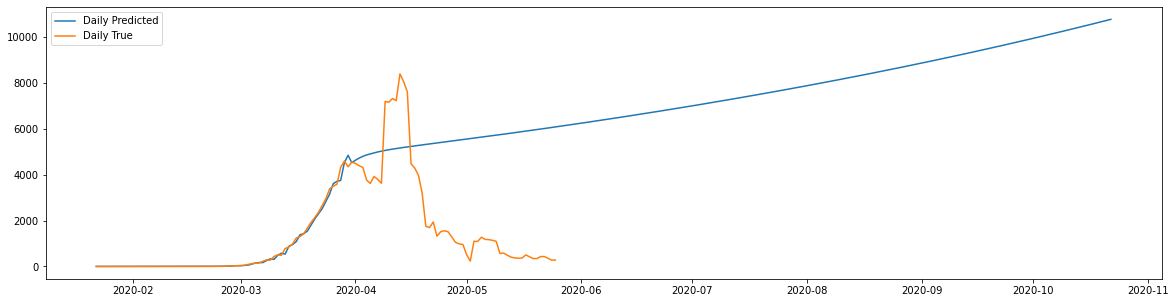

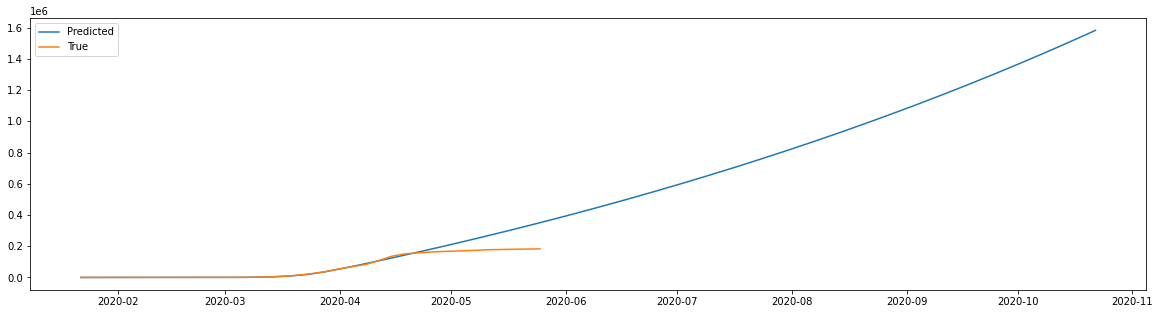

In [ ]:
forecast_regions = ['France']
forecast_start_date = '2020-04-01'
forecast_average_size = 7
pad_start = sequence_length
days_ahead = 150

forecast_data, scaler = get_data(sdf, regions=forecast_regions, partial_match=True,
                                 normalization=data_normalization, pad_start=pad_start, pad_end=days_ahead, 
                                 average_size=forecast_average_size, normalize_by_first_case=False)

forecast_start_day = np.where(forecast_data.index == pd.to_datetime(forecast_start_date))[0][0] - pad_start if forecast_start_date else None
forecast_generator = get_sequence_generator(forecast_data, length=sequence_length, normalization=None, shuffle=False, batch_size=1)
preds, trues = forecast(models, forecast_generator, forecast_start_day=forecast_start_day, normalization=block_normalization)

predicted_df = pd.DataFrame(preds, columns=forecast_data.columns, index=forecast_data.index[sequence_length:])
trues_df = pd.DataFrame(trues, columns=forecast_data.columns, index=forecast_data.index[sequence_length:])

if scaler:
    predicted_df.iloc[:, :] = scaler.inverse_transform(predicted_df.values)
    trues_df.iloc[:, :] = scaler.inverse_transform(trues_df.values)

pd.DataFrame(np.stack([predicted_df.sum(axis=1).values, trues_df.sum(axis=1, min_count=1).values], axis=1), 
             columns=['Daily Predicted', 'Daily True'], index=predicted_df.index).plot(figsize=(20, 5))
pd.DataFrame(np.stack([predicted_df.sum(axis=1).cumsum().values, trues_df.sum(axis=1, min_count=1).cumsum().values], axis=1), 
             columns=['Predicted', 'True'], index=predicted_df.index).plot(figsize=(20, 5))

mape = pd.DataFrame(np.expand_dims(mean_absolute_percentage_error(trues_df.values, predicted_df.values), axis=0),
                    columns = trues_df.columns)
corr = predicted_df.corrwith(trues_df)
stats = pd.DataFrame(np.concatenate([mape.T.values, np.expand_dims(corr.values, -1)], axis=1), columns=['MAPE', 'XCOR'], index=corr.index)
print(stats)
print(stats.mean())

#### Save Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
workspace = '/content/drive/My Drive/Colab Notebooks/COVID19'
df_folder = workspace + '/experiments/Transformers-v000/'
predicted_df.to_csv(df_folder + 'predictions.csv')
trues_df.to_csv(df_folder + 'trues.csv')

for i, model in enumerate(models):
    model.save_weights(df_folder + 'models/model%d.h5' % i)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Generate Report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

workspace = '/content/drive/My\ Drive/Colab\ Notebooks/COVID19/'
nb_name = 'COVID19\ Time\ Series\ -\ Multi\ Head\ Attention'
!cp {workspace + nb_name} .
!jupyter nbconvert  {nb_name}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook COVID19 Time Series - Multi Head Attention to html
[NbConvertApp] Writing 2102090 bytes to COVID19 Time Series - Multi Head Attentio.html
